In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from datetime import datetime
import shutil

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
sess = tf.Session(config=tf_config)

import sys
from pathlib import Path

import keras
import pandas as pd
from keras import backend as K
from keras import layers, models, optimizers, regularizers
from keras.initializers import Constant
from keras.callbacks import CSVLogger, LearningRateScheduler, ModelCheckpoint
from keras.layers import (
    Activation,
    BatchNormalization,
    Concatenate,
    Conv1D,
    Conv2D,
    Conv2DTranspose,
    Concatenate,
    Dense,
    Dropout,
    Flatten,
    Input,
    Lambda,
    Layer,
    MaxPooling2D,
    AveragePooling2D,
    PReLU,
    Reshape,
    Softmax,
)
from keras.utils import to_categorical, multi_gpu_model

keras.__version__

Using TensorFlow backend.


'2.3.1'

In [2]:
## Change to your own path
path_photoz = "/jet/home/gvincent/encapZulate-1/src"

sys.path.insert(1, path_photoz)
path_photoz = Path(path_photoz)

In [3]:
from encapzulate.data_loader.data_loader import load_data, DataGenerator, load_GOES, load_RMW
from encapzulate.models.multi_gpu import MultiGPUModel
from encapzulate.utils import metrics
from encapzulate.utils.fileio import load_config, load_model

In [4]:
CONFIG_FILE = 'galen_CNN-baseline.yml'
config = load_config(path_photoz / "encapzulate" / "configs" / CONFIG_FILE, verbose = False)
config["input_shape"] = config["image_shape"]
config["num_gpus"] = 4
#config['dataset'] = 'satellite_images_dev'
#config['dataset_aux'] = 'tc_data_dev'
#config["run_name"] = "CNNbaseline_no-transfer-learning"
config["epochs"] = 25
config["batch_size"] = 200
config["class_weights"] = [1.0, 1.0]
config["learning_rate"] = 1e-5
config

{'run_name': 'CNNbaseline',
 'num_gpus': 4,
 'compile_on': 'cpu',
 'path_data': '/ocean/projects/dms190029p/gvincent/tc-rmw-data',
 'dataset': 'satellite_images_clean',
 'dataset_aux': 'tc_data_clean',
 'dataloader': 'RMW',
 'image_shape': (200, 200, 1),
 'class_var': 'intensity',
 'eye_check': 'include',
 'num_class': 3,
 'max_year_train': 2016,
 'max_year_dev': 2018,
 'random_state': 200,
 'image_scale': 50.0,
 'class_weights': [1.0, 1.0],
 'grid_scale': 4.0,
 'model_name': None,
 'routings': 3,
 'dim_capsule': 16,
 'batch_size': 200,
 'epochs': 25,
 'checkpoint': None,
 'learning_rate': 1e-05,
 'decay_rate': 0.95,
 'lam_recon': 0.75,
 'hwhm': 175.0,
 'timeline': False,
 'path_results': None,
 'input_shape': (200, 200, 1)}

In [5]:
path_output = "/jet/home/gvincent/encapZulate-1/src/results"
path_output = Path(path_output)
path_results = path_output / config["run_name"] / (datetime.today().strftime('%Y-%m-%d'))

path_classification = path_results / "classification_step"
path_c_logs = path_classification / "logs"
path_c_weights = path_classification / "weights"

path_regression = path_results / "regression_step"
path_r_goes = path_regression / "goes"
path_r_goes_ebt = path_regression/"goes_and_ebt"

path_r_logs = path_r_goes / "logs"
path_r_weights = path_r_goes / "weights"

path_r_ebt_logs = path_r_goes_ebt / "logs"
path_r_ebt_weights = path_r_goes_ebt / "weights"

In [41]:
path_c_logs.mkdir(parents=True, exist_ok=True)
path_c_weights.mkdir(parents=True, exist_ok=True)
path_r_logs.mkdir(parents=True, exist_ok=True)
path_r_weights.mkdir(parents=True, exist_ok=True)
path_r_ebt_logs.mkdir(parents=True, exist_ok=True)
path_r_ebt_weights.mkdir(parents=True, exist_ok=True)

pd.Series(config).to_csv(path_results / "config.csv") # Save config file used

# Intensity Classifier Step

In [17]:
((x_train, y_train, rmw_train, aux_train),
 (x_dev, y_dev, rmw_dev, aux_dev),
 (x_test, y_test, rmw_test, aux_test)) = load_GOES(**config)

max_year_train = config['max_year_train']
max_year_dev = config['max_year_dev']
print(f'Training (2000 - {max_year_train}): {x_train.shape}\n')
print(f'Validation ({max_year_train + 1} - {max_year_dev}): {x_dev.shape}\n')
print(f'Testing ({max_year_dev + 1} - 2020): {x_test.shape}\n')
print(f'Total: {x_train.shape[0] + x_dev.shape[0] + x_test.shape[0]}')

Training (2000 - 2016): (53880, 200, 200, 1)

Validation (2017 - 2018): (8571, 200, 200, 1)

Testing (2019 - 2020): (9144, 200, 200, 1)

Total: 71595


In [6]:
# Define classifier model 

DROPUOUT_FRAC = 0.5
def TranferNet(input_shape, verbose = True, **kwargs):
    
    x = Input(shape=input_shape)
    l = x
    
    l = Conv2D(
        25,
        (5, 5),
        strides=(1, 1),
        activation=None,
        padding="valid",
        kernel_initializer="he_normal",
    )(l)
    l = PReLU(shared_axes = [1, 2])(l)
    
    l = AveragePooling2D(pool_size = (2, 2))(l)
    
    l = Conv2D(
        25,
        (5, 5),
        strides=(1, 1),
        activation=None,
        padding="valid",
        kernel_initializer="he_normal",
    )(l) 
    l = PReLU(shared_axes = [1, 2])(l)
    
    l = Conv2D(
        25,
        (5, 5),
        strides=(1, 1),
        activation=None,
        padding="valid",
        kernel_initializer="he_normal",
    )(l) 
    l = PReLU(shared_axes = [1, 2])(l)
    
    l = AveragePooling2D(pool_size = (2, 2))(l)
    
    l = Conv2D(
        25,
        (5, 5),
        strides=(1, 1),
        activation=None,
        padding="valid",
        kernel_initializer="he_normal",
    )(l) 
    l = PReLU(shared_axes = [1, 2])(l)
    
    l = Conv2D(
        25,
        (5, 5),
        strides=(1, 1),
        activation=None,
        padding="valid",
        kernel_initializer="he_normal",
    )(l) 
    l = PReLU(shared_axes = [1, 2])(l)
    
    l = AveragePooling2D(pool_size = (2, 2))(l)
    
    l = Conv2D(
        20,
        (5, 5),
        strides=(1, 1),
        activation=None,
        padding="valid",
        kernel_initializer="he_normal",
    )(l) 
    l = PReLU(shared_axes = [1, 2])(l)
    out1 = l
    
    l = Flatten()(l)
    l = Dense(
        548,
        kernel_initializer="he_normal",
    )(l)
    l = PReLU()(l)
    l = Dropout(DROPUOUT_FRAC)(l)
    
    l = Dense(
        548,
        kernel_initializer="he_normal",
    )(l)
    l = PReLU()(l)
    l = Dropout(DROPUOUT_FRAC)(l)

    l = Dense(
        3,
        kernel_initializer="he_normal"
    )(l)
    
    cnn_filter_model = models.Model(x, out1, name = 'filters') # This model will be frozen and used later for RMW regression
    classifier_model = models.Model(x, l, name = 'classifier') # This is the full classification model
    
    if verbose:
        print(classifier_model.summary())

    return cnn_filter_model, classifier_model

In [13]:
filter_model, classifier_model = TranferNet(verbose = False, **config)
parallel_model = MultiGPUModel(classifier_model, gpus=config['num_gpus']) # configure for multi-GPU
classifier_model = parallel_model

In [14]:
# Compile model
CLASSIFIER_LEARNING_RATE = 1e-5
CLASSIFIER_DECAY_RATE = 0.985
CLASSIFIER_EPOCHS = 25

compile_kwargs = {
                "optimizer": optimizers.Adam(lr=CLASSIFIER_LEARNING_RATE),
                "loss": tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                "metrics": [
                    'accuracy',
                    tf.keras.metrics.Precision(class_id = 0, name = 'TS_prec'),
                    tf.keras.metrics.Recall(class_id = 0, name = 'TS_recall'),
                    tf.keras.metrics.Precision(class_id = 1, name = 'HU_prec'),
                    tf.keras.metrics.Recall(class_id = 1, name = 'HU_recall'),
                    tf.keras.metrics.Precision(class_id = 2, name = 'MH_prec'),
                    tf.keras.metrics.Recall(class_id = 2, name = 'MH_recall'),
                ]
            }

classifier_model.compile(**compile_kwargs)

In [15]:
# Set Callbacks
lr_decay = LearningRateScheduler(
    schedule=lambda epoch: CLASSIFIER_LEARNING_RATE * (CLASSIFIER_DECAY_RATE ** epoch)
)
log = CSVLogger(str(path_c_logs / "log.csv"))
cp = ModelCheckpoint(
    filepath=str(path_c_weights / "weights-{epoch:02d}.h5"),
    save_best_only=False,
    save_weights_only=True,
    verbose=1
)

In [ ]:
# Load weight from file
EVAL_EPOCH = '25'
weights_path = path_c_weights / f'weights-{EVAL_EPOCH}.h5'
classifier_model.load_weights(weights_path)

# OR Train below

In [18]:
# Oversampling to weight classes

training_generator = DataGenerator(x_train, y_train, config["batch_size"], class_weights = [1.0, 1.0, 1.0], capsnet = False)
validation_generator = DataGenerator(x_dev, y_dev, config["batch_size"], class_weights = [1.0, 1.0, 1.0], capsnet = False)

classifier_model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    epochs=CLASSIFIER_EPOCHS,
    initial_epoch=0,
    callbacks=[log, cp, lr_decay],
    use_multiprocessing=True,
    workers=20,
)


Epoch 1/25
524/524 [==============================] - 48s 92ms/step - loss: 0.8601 - accuracy: 0.5960 - TS_prec: 0.5373 - TS_recall: 0.5865 - HU_prec: 0.3630 - HU_recall: 0.4387 - MH_prec: 0.5277 - MH_recall: 0.6446 - val_loss: 0.8183 - val_accuracy: 0.6309 - val_TS_prec: 0.6417 - val_TS_recall: 0.7049 - val_HU_prec: 0.3892 - val_HU_recall: 0.5211 - val_MH_prec: 0.6182 - val_MH_recall: 0.7282

Epoch 00001: saving model to /jet/home/gvincent/encapZulate-1/src/results/CNNbaseline/2022-05-10/classification_step/weights/weights-01.h5
Epoch 2/25
524/524 [==============================] - 35s 66ms/step - loss: 0.6557 - accuracy: 0.7039 - TS_prec: 0.6594 - TS_recall: 0.7447 - HU_prec: 0.4008 - HU_recall: 0.5778 - MH_prec: 0.6484 - MH_recall: 0.7562 - val_loss: 0.7423 - val_accuracy: 0.6670 - val_TS_prec: 0.6706 - val_TS_recall: 0.7711 - val_HU_prec: 0.4084 - val_HU_recall: 0.6142 - val_MH_prec: 0.6722 - val_MH_recall: 0.7754

Epoch 00002: saving model to /jet/home/gvincent/encapZulate-1/src/

# Fit RMW Regression Models

In [19]:
# Load RMW data near ATCF observations
((x_train_2, y_train_2, rmw_train_2, ebt_train_2, aux_train_2),
 (x_dev_2, y_dev_2, rmw_dev_2, ebt_dev_2, aux_dev_2),
 (x_test_2, y_test_2, rmw_test_2, ebt_test_2, aux_test_2)) = load_RMW(**config)

max_year_train = config['max_year_train']
max_year_dev = config['max_year_dev']
print(f'Training (2000 - {max_year_train}): {x_train_2.shape}\n')
print(f'Validation ({max_year_train + 1} - {max_year_dev}): {x_dev_2.shape}\n')
print(f'Testing ({max_year_dev + 1} - 2020): {x_test_2.shape}\n')
print(f'Total: {x_train_2.shape[0] + x_dev_2.shape[0] + x_test_2.shape[0]}')

Training (2000 - 2016): (1558, 200, 200, 1)

Validation (2017 - 2018): (214, 200, 200, 1)

Testing (2019 - 2020): (113, 200, 200, 1)

Total: 1885


In [20]:
# Freeze CNN filter weights
filter_model.trainable = False

In [21]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.pow(y_true - y_pred, 2)))

### GOES Only

In [22]:
# Define RMW regression model as a function of the frozen filters 
def RMW_Model(input_shape, filter_model, dropout_frac, verbose=False):
    x1 = Input(shape=input_shape)
    l = x1
    
    l = filter_model(l)
    l = BatchNormalization()(l)
    
    l = Flatten()(l)
    
    l = Dense(
        275,
        kernel_initializer="he_normal",
    )(l)
    l = PReLU()(l)
    l = Dropout(dropout_frac)(l)
    
    l = Dense(
        275,
        kernel_initializer="he_normal",
    )(l)
    l = PReLU()(l)
    l = Dropout(dropout_frac)(l)

    l = Dense(
        1,
        kernel_initializer="he_normal"
    )(l)
    
    model_to_return = models.Model(x1, l, name = 'rmw_model')
    
    if verbose:
        print(model_to_return.summary())

    return model_to_return
    

In [23]:
rmw_model = RMW_Model(config['input_shape'], filter_model, 0.5, verbose = True)
parallel_model = MultiGPUModel(rmw_model, gpus=config['num_gpus'])
rmw_model = parallel_model

Model: "rmw_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 200, 200, 1)       0         
_________________________________________________________________
filters (Model)              (None, 14, 14, 20)        75915     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 20)        80        
_________________________________________________________________
flatten_4 (Flatten)          (None, 3920)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 275)               1078275   
_________________________________________________________________
p_re_lu_25 (PReLU)           (None, 275)               275       
_________________________________________________________________
dropout_7 (Dropout)          (None, 275)               0 

In [37]:
# Compile model
REGRESSION_LEARNING_RATE = 1e-4
REGRESSION_DECAY_RATE = 0.95
REGRESSION_EPOCHS = 100

compile_kwargs_rmw = {
                "optimizer": optimizers.Adam(lr=REGRESSION_LEARNING_RATE),
                "loss": tf.keras.losses.MeanSquaredError(name = 'mse'),
                "metrics": [rmse]
            }

rmw_model.compile(**compile_kwargs_rmw)

In [25]:
# Set Callbacks
lr_decay_reg = LearningRateScheduler(
    schedule=lambda epoch: REGRESSION_LEARNING_RATE * (REGRESSION_DECAY_RATE ** epoch)
)
log_reg = CSVLogger(str(path_r_logs / "log.csv"))
cp_reg = ModelCheckpoint(
    filepath=str(path_r_weights / "weights-{epoch:02d}.h5"),
    save_best_only=True,
    monitor = 'val_loss',
    mode = 'min',
    save_weights_only=True,
    verbose=1
)

In [38]:
# Load weight from file
EVAL_EPOCH = '100'
weights_path = path_r_weights / f'weights-{EVAL_EPOCH}.h5'
rmw_model.load_weights(weights_path)

# OR Train below

In [ ]:
# Fit model
rmw_model.fit(
    x_train_2, 
    rmw_train_2,
    batch_size=200, 
    epochs=REGRESSION_EPOCHS,
    initial_epoch=0,
    validation_data=[x_dev_2, rmw_dev_2],
    callbacks=[log_reg, cp_reg, lr_decay_reg],
)

### GOES + EBT

In [32]:
# Define RMW regression model as a function of the frozen filters 
def RMW_Model_EBT(input_shape, filter_model, dropout_frac, verbose=False):
    
    x1 = Input(shape=input_shape)
    l = x1
    
    l = filter_model(l)
    l = BatchNormalization()(l)
    
    x2 = Input(shape=(5,))
    
    l = Flatten()(l)
    l = Concatenate()([l, x2])
    
    l = Dense(
        275,
        kernel_initializer="he_normal",
    )(l)
    l = PReLU()(l)
    l = Dropout(dropout_frac)(l)
    
    l = Dense(
        275,
        kernel_initializer="he_normal",
    )(l)
    l = PReLU()(l)
    l = Dropout(dropout_frac)(l)

    l = Dense(
        1,
        kernel_initializer="he_normal"
    )(l)
    
    model_to_return = models.Model([x1, x2], l, name = 'rmw_ebt_model')
    
    if verbose:
        print(model_to_return.summary())

    return model_to_return
    

In [56]:
rmw_model_ebt = RMW_Model_EBT(config['input_shape'], filter_model, 0.5, verbose = True)
parallel_model = MultiGPUModel(rmw_model_ebt, gpus=config['num_gpus'])
rmw_model_ebt = parallel_model

Model: "rmw_ebt_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
filters (Model)                 (None, 14, 14, 20)   75915       input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 14, 14, 20)   80          filters[5][0]                    
__________________________________________________________________________________________________
flatten_8 (Flatten)             (None, 3920)         0           batch_normalization_5[0][0]      
______________________________________________________________________________________

In [58]:
# Compile model
REGRESSION_EBT_LEARNING_RATE = 1e-5
REGRESSION_EBT_DECAY_RATE = 0.97
REGRESSION_EBT_EPOCHS = 200


compile_kwargs_rmw_ebt = {
                "optimizer": optimizers.Adam(lr=REGRESSION_EBT_LEARNING_RATE),
                "loss": tf.keras.losses.MeanSquaredError(name = 'mse'),
                "metrics": [rmse]
            }

rmw_model_ebt.compile(**compile_kwargs_rmw_ebt)

In [59]:
# Set Callbacks
lr_decay_reg_ebt = LearningRateScheduler(
    schedule=lambda epoch: REGRESSION_EBT_LEARNING_RATE * (REGRESSION_EBT_DECAY_RATE ** epoch)
)
log_reg_ebt = CSVLogger(str(path_r_ebt_logs / "log.csv"))
cp_reg_ebt = ModelCheckpoint(
    filepath=str(path_r_ebt_weights / "weights-{epoch:02d}.h5"),
    save_best_only=True,
    monitor = 'val_loss',
    mode = 'min',
    save_weights_only=True,
    verbose=1
)

In [60]:
# Fit model
rmw_model_ebt.fit(
    [x_train_2, ebt_train_2],
    rmw_train_2,
    batch_size=200, 
    epochs=REGRESSION_EBT_EPOCHS,
    initial_epoch=0,
    validation_data=[[x_dev_2, ebt_dev_2], rmw_dev_2],
    callbacks=[log_reg_ebt, cp_reg_ebt, lr_decay_reg_ebt],
)

Train on 1558 samples, validate on 214 samples
Epoch 1/200
1558/1558 [==============================] - 5s 3ms/step - loss: 4874.8911 - rmse: 69.8712 - val_loss: 4709.9331 - val_rmse: 69.5930

Epoch 00001: val_loss improved from inf to 4709.93311, saving model to /jet/home/gvincent/encapZulate-1/src/results/CNNbaseline/2022-05-10/regression_step/goes_and_ebt/weights/weights-01.h5
Epoch 2/200
1558/1558 [==============================] - 1s 326us/step - loss: 4796.9524 - rmse: 69.1075 - val_loss: 4682.7715 - val_rmse: 69.3181

Epoch 00002: val_loss improved from 4709.93311 to 4682.77153, saving model to /jet/home/gvincent/encapZulate-1/src/results/CNNbaseline/2022-05-10/regression_step/goes_and_ebt/weights/weights-02.h5
Epoch 3/200
1558/1558 [==============================] - 1s 328us/step - loss: 4761.4745 - rmse: 68.9613 - val_loss: 4636.0176 - val_rmse: 68.8615

Epoch 00003: val_loss improved from 4682.77153 to 4636.01761, saving model to /jet/home/gvincent/encapZulate-1/src/results/C

KeyboardInterrupt: 

In [45]:
preds = rmw_model_ebt.predict([x_dev_2, ebt_dev_2]).flatten()
resid = preds - rmw_dev_2
print(f'MSE: {np.mean(np.power(resid, 2))}')
print(f'RMSE: {np.sqrt(np.mean(np.power(resid, 2)))}')

MSE: 880.3210027647272
RMSE: 29.670203955563352


In [48]:
preds = rmw_model_ebt.predict([x_train_2, ebt_train_2]).flatten()
resid = preds - rmw_train_2
print(f'MSE: {np.mean(np.power(resid, 2))}')
print(f'RMSE: {np.sqrt(np.mean(np.power(resid, 2)))}')

MSE: 995.9332488717633
RMSE: 31.558410113181612


# Fine Tune the Regression Model

In [49]:
# Unfreeze the CNN layers for fine tuning
filter_model.trainable = True

In [50]:
## GOES Model
#model_to_tune = rmw_model
#reg_epochs = REGRESSION_EPOCHS
#log_to_append = path_r_logs
#cp_to_append = cp_reg

# GOES + EBT Model
model_to_tune = rmw_model_ebt
reg_epochs = REGRESSION_EBT_EPOCHS
log_to_append = path_r_ebt_logs
cp_to_append = cp_reg_ebt

In [52]:
# Compile model
TUNE_LEARNING_RATE = 1e-5 # For transfer learning
#TUNE_LEARNING_RATE = 1e-4 # For non transfer learning
TUNE_DECAY_RATE = 0.98 # For transfer learning
#TUNE_DECAY_RATE = 0.95 # For non-transfer learning
TUNE_EPOCHS = 500

#REGRESSION_EPOCHS = 0 # For non-transfer learning

compile_kwargs_tune = {
                "optimizer": optimizers.Adam(lr=TUNE_LEARNING_RATE),
                "loss": tf.keras.losses.MeanSquaredError(name = 'mse'),
                "metrics": [rmse]
            }

model_to_tune.compile(**compile_kwargs_tune)

In [53]:
lr_decay_tune = LearningRateScheduler(
    schedule=lambda epoch: TUNE_LEARNING_RATE * (TUNE_DECAY_RATE ** (epoch - reg_epochs))
)
log_tune = CSVLogger(str(log_to_append / "log.csv"), append = True)

In [ ]:
# GOES model
model_to_tune.fit(
    x_train_2,
    rmw_train_2,
    batch_size=200, 
    epochs=TUNE_EPOCHS,
    initial_epoch=reg_epochs,
    validation_data=[x_dev_2, rmw_dev_2],
    callbacks=[log_tune, cp_reg, lr_decay_tune],
)

In [55]:
# GOES + EBT model
model_to_tune.fit(
    [x_train_2, ebt_train_2],
    rmw_train_2,
    batch_size=200, 
    epochs=TUNE_EPOCHS,
    initial_epoch=reg_epochs,
    validation_data=[[x_dev_2, ebt_dev_2], rmw_dev_2],
    callbacks=[log_tune, cp_reg_ebt, lr_decay_tune],
)

Train on 1558 samples, validate on 214 samples
Epoch 101/500
1558/1558 [==============================] - 5s 3ms/step - loss: 1104.3933 - rmse: 33.1034 - val_loss: 869.4589 - val_rmse: 26.1652

Epoch 00101: val_loss improved from 879.99612 to 869.45891, saving model to /jet/home/gvincent/encapZulate-1/src/results/CNNbaseline/2022-05-10/regression_step/goes_and_ebt/weights/weights-101.h5
Epoch 102/500
1558/1558 [==============================] - 1s 373us/step - loss: 1173.8987 - rmse: 34.1033 - val_loss: 881.6263 - val_rmse: 26.4743

Epoch 00102: val_loss did not improve from 869.45891
Epoch 103/500
1558/1558 [==============================] - 1s 368us/step - loss: 1150.2411 - rmse: 33.9236 - val_loss: 872.4314 - val_rmse: 26.2523

Epoch 00103: val_loss did not improve from 869.45891
Epoch 104/500
1558/1558 [==============================] - 1s 367us/step - loss: 1130.4614 - rmse: 33.4524 - val_loss: 868.9870 - val_rmse: 26.2030

Epoch 00104: val_loss improved from 869.45891 to 868.9870

KeyboardInterrupt: 

In [30]:
rmw_model.evaluate(x_dev_2, rmw_dev_2)

214/214 [==============================] - 1s 3ms/step


[893.8514700916326, 33.2125129699707]

In [31]:
np.sqrt(893.8514700916326)

29.8973488806555

In [34]:
preds = rmw_model.predict(x_dev_2).flatten()

In [38]:
np.mean((preds - rmw_dev_2)**2)

893.8514939274334

In [39]:
np.sqrt(np.mean((preds - rmw_dev_2)**2))

29.897349279282828

## Ignore section below, this is code to test out binned regression

In [ ]:
## Doing stuff to test out binned regression

bins = np.arange(np.min(rmw_train) - 2.5, np.max(rmw_train) + 2.5, 5)
rmw_train_binned = keras.utils.to_categorical(
    np.digitize(rmw_train, bins) - 1,
    num_classes = len(bins)
)

rmw_dev_binned = keras.utils.to_categorical(
    np.digitize(rmw_dev, bins) - 1,
    num_classes = len(bins)
)

compile_kwargs = {
                "optimizer": optimizers.Adam(lr=config["learning_rate"]),
                "loss": 'categorical_crossentropy',
                "metrics": ['accuracy']
            }

train_model.compile(**compile_kwargs)


# Set Callbacks
lr_decay = LearningRateScheduler(
    schedule=lambda epoch: 1e-4 * (config["decay_rate"] ** epoch)
)
log = CSVLogger(str(path_logs / "log.csv"))
cp = ModelCheckpoint(
    filepath=str(path_weights / "weights-{epoch:02d}.h5"),
    save_best_only=False,
    save_weights_only=True,
    verbose=1,
    mode="max",
)

# Straight weighting of the loss function to weight classes

train_model.fit(
            x_train,
            rmw_train_binned,
            batch_size=config["batch_size"],
            epochs=config["epochs"],
            initial_epoch=0,
            validation_data=[x_dev, rmw_dev_binned],
            callbacks=[log, cp, lr_decay],
        )

# Training Visualization

### Classifier

In [14]:
train_log = pd.read_csv(path_c_logs / 'log.csv')

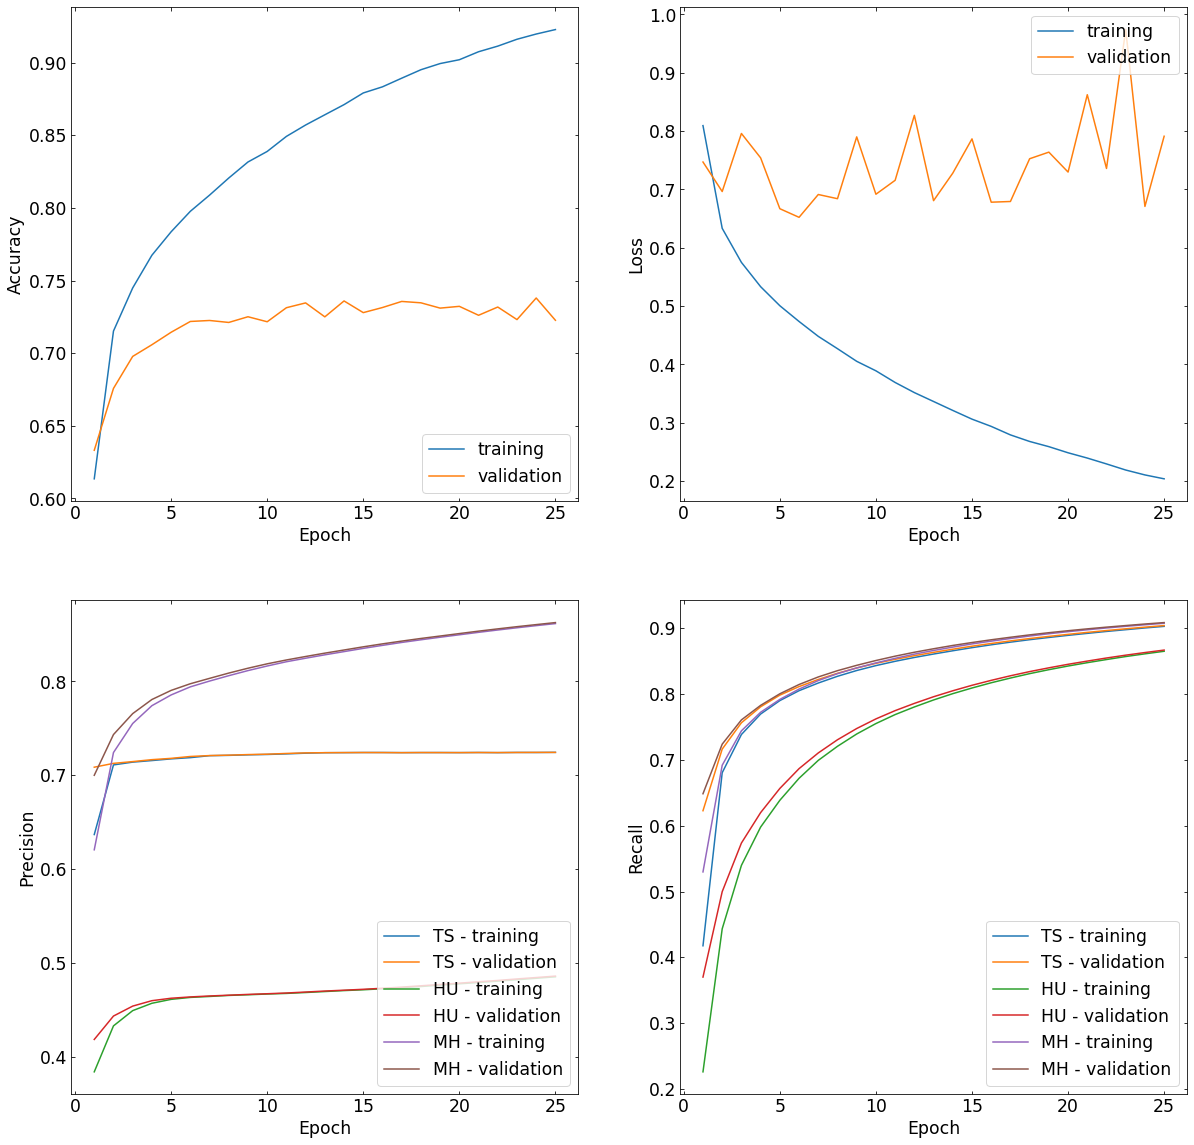

In [15]:
x = train_log.epoch + 1

font = {'size': 12}
plt.rc('font', **font)

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 20))

axs[0,0].plot(x, train_log.accuracy, label = 'training')
axs[0,0].plot(x, train_log.val_accuracy, label = 'validation')
axs[0,0].legend(loc = 'lower right')
#ax1.set_ylim([0.5, 1])
axs[0,0].set_xlabel('Epoch')
axs[0,0].set_ylabel('Accuracy')

axs[0,1].plot(x, train_log.loss, label = 'training')
axs[0,1].plot(x, train_log.val_loss, label = 'validation')
axs[0,1].legend(loc = 'upper right')
axs[0,1].set_xlabel('Epoch')
axs[0,1].set_ylabel('Loss')

axs[1,0].plot(x, train_log.TS_prec, label = 'TS - training')
axs[1,0].plot(x, train_log.val_TS_prec, label = 'TS - validation')
axs[1,0].plot(x, train_log.HU_prec, label = 'HU - training')
axs[1,0].plot(x, train_log.val_HU_prec, label = 'HU - validation')
axs[1,0].plot(x, train_log.MH_prec, label = 'MH - training')
axs[1,0].plot(x, train_log.val_MH_prec, label = 'MH - validation')
axs[1,0].legend(loc = 'lower right')
axs[1,0].set_xlabel('Epoch')
axs[1,0].set_ylabel('Precision')

axs[1,1].plot(x, train_log.TS_recall, label = 'TS - training')
axs[1,1].plot(x, train_log.val_TS_recall, label = 'TS - validation')
axs[1,1].plot(x, train_log.HU_recall, label = 'HU - training')
axs[1,1].plot(x, train_log.val_HU_recall, label = 'HU - validation')
axs[1,1].plot(x, train_log.MH_recall, label = 'MH - training')
axs[1,1].plot(x, train_log.val_MH_recall, label = 'MH - validation')
axs[1,1].legend(loc = 'lower right')
axs[1,1].set_xlabel('Epoch')
axs[1,1].set_ylabel('Recall')

plt.show()

### Regression

In [29]:
train_log_reg = pd.read_csv(path_r_logs / 'log.csv')

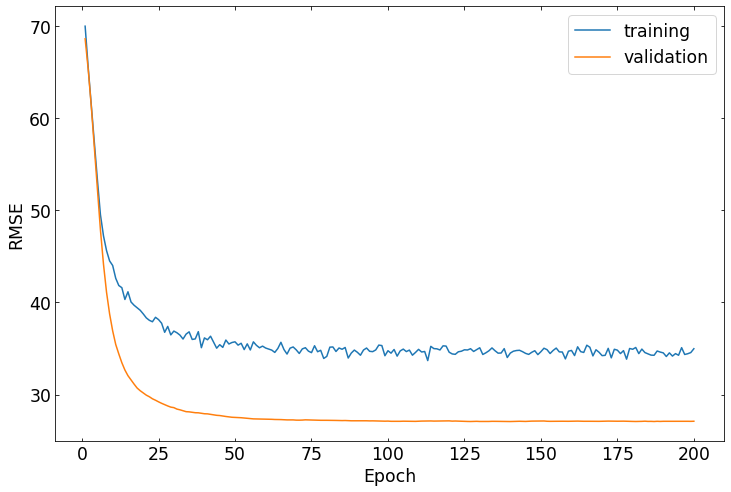

In [31]:
x = train_log_reg.epoch + 1

font = {'size': 12}
plt.rc('font', **font)

fig = plt.figure(figsize = (12, 8))
ax1 = fig.gca()

ax1.plot(x, train_log_reg.rmse, label = 'training')
ax1.plot(x, train_log_reg.val_rmse, label = 'validation')
ax1.legend(loc = 'upper right')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('RMSE')

plt.show()

In [43]:
np.min(train_log_reg.val_loss)

888.9376406090283

In [44]:
np.sqrt(888.9376406090283)

29.815057279989055

### Further Regression evaluation

In [53]:
x_fulltest = np.concatenate((x_test_2, x_dev_2))
x_fulltest.shape

(327, 200, 200, 1)

In [54]:
rmw_fulltest = np.concatenate((rmw_test_2, rmw_dev_2))
rmw_fulltest.shape

(327,)

In [ ]:
out = rmw_model.predict(x_fulltest).flatten()
out.shape

In [ ]:
resid = rmw_fulltest - out

In [ ]:
plt.scatter(rmw_fulltest, resid)

In [ ]:
fig = plt.figure(figsize = (8, 8))
plt.scatter(rmw_fulltest, out_preds)
plt.plot([0, 200], [0, 200], color = 'red')
plt.xlim([0, 200])
plt.ylim([0, 200])
plt.gca().set_aspect('equal')

In [55]:
#Climatology RMSE:
clima = np.mean(rmw_train_2)
print(f'Climatology RMSE: {np.sqrt(np.mean((clima - rmw_fulltest)**2))}')

Climatology RMSE: 40.61226962210578


### TODO Next:
* Implement the "binned regression" that the SDSS paper uses
* Add dropout to help with overfitting
* Pre-train classication network on storm category (or eye/no eye), then do a few epochs update for RMW
    * Try both freezing CNN weights and only training dense layer, and not freezing anything
    * Try augmentation... it could be worth it!
* Try the RMW model above **wihtout** transfer learning and see what happens
* Fit a linear baseline using only EOFs
* Add other EBT variables to this NN baseline model
* Compare to Knaff's results
* Mess with the network architecture some, if you feel like it
* Move on to getting ground truth labels for "apparent eye" from radial profiles, as discussed with Trey in Thursday 5/5 meeting